# File Ingestion

## Setup

Using local config file (see [01_pipeline](./01_pipeline.ipynb))

In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
import datajoint as dj; dj.conn()
from adamacs.pipeline import subject, behavior, session, event, trial
from adamacs.ingest import behavior as ibe


[2023-07-23 18:38:57,665][INFO]: Connecting tobiasr@172.26.128.53:3306
[2023-07-23 18:38:57,712][INFO]: Connected tobiasr@172.26.128.53:3306


Manual entry

### BPod Path Setup

Your `dj.config` file should have a section for your BPod root directory under `custom`: `exp_root_data_dir`. This is a list of one or more paths where the ingestion tool will look for the relative paths it is given.

In [2]:
import datajoint as dj
from element_interface.utils import find_full_path
from adamacs.pipeline import session, event, trial
from adamacs.ingest.bpod import Bpodfile
from adamacs.paths import get_experiment_root_data_dir

bpod_path = "DB_WEZ-8701_2022-03-18_scan9FB2LN5C_sess9FB2LN5C/scan9FB2LN5C_WEZ-8701_StimArenaMaster_20220318_165447.mat"
# bpod_path = "TR_WEZ-8701_2023-01-13_scan9FG1THFD_sess9FG1TAXY/scan9FG1THFD_WEZ-8701_StimArenaMaster_20230113_172307.mat"

root_dirs = dj.config["custom"]["exp_root_data_dir"]
bpod_path_full = find_full_path(get_experiment_root_data_dir(),bpod_path)

print(f"Root: {root_dirs}\nFull: {bpod_path_full}")

Root: ['/datajoint-data/data/tobiasr']
Full: /datajoint-data/data/tobiasr/DB_WEZ-8701_2022-03-18_scan9FB2LN5C_sess9FB2LN5C/scan9FB2LN5C_WEZ-8701_StimArenaMaster_20220318_165447.mat


### Initial check of tables

In [3]:
# from adamacs.pipeline import session, event, trial

# session.Session.delete()


# print('Sessions:', len(session.Session()))
# print('Trials  :', len(trial.Trial()))
# print('Events  :', len(event.Event()))

In [4]:
# event.EventType.delete()

In [5]:
event.BehaviorRecording()

session_id,scan_id,recording_start_time,recording_duration,recording_notes
sess9FHS7Y22,scan9FHS7Y22,2023-04-28 12:42:33,620.0,
sess9FIBUH7F,scan9FIBUH7F,2023-05-31 11:55:22,360.0,
sess9FJ1ISOK,scan9FJ1ISOK,2023-07-13 14:51:06,620.0,
sess9FJ22934,scan9FJ22934,2023-07-14 12:43:11,320.0,
sess9FJ4IJK9,scan9FJ4IJK9,2023-07-18 15:34:42,320.0,
sess9FJ5PTCQ,scan9FJ5PTCQ,2023-07-20 16:01:50,320.0,


In [6]:
dj.Diagram(behavior)+dj.Diagram(event)+dj.Diagram(trial)

ValueError: Node names and attributes should not contain ":" unless they are quoted with "".                    For example the string 'attribute:data1' should be written as '"attribute:data1"'.                    Please refer https://github.com/pydot/pydot/issues/258

## Automated BPod ingestion

The function is designed ask for a confirmation before entered into the schema.

In [7]:
session.Session()

session_id,subject PyRat import uses this for earmark value,session_datetime
sess9FB2LN5C,WEZ-8701,2022-03-18 00:00:00
sess9FHS7Y22,ROS-1485,2023-04-28 00:00:00
sess9FI8ETDQ,ROS-1518,2023-05-25 00:00:00
sess9FIBUH7F,WEZ-8869,2023-05-31 00:00:00
sess9FJ1ISOK,WEZ-8873,2023-07-13 00:00:00
sess9FJ22934,ROS-1576,2023-07-14 00:00:00
sess9FJ4IJK9,ROS-1576,2023-07-18 00:00:00
sess9FJ4IJOQ,ROS-1518,2023-07-18 00:00:00
sess9FJ5PTCQ,OPI-1681,2023-07-20 00:00:00


In [8]:
bpod_path = "DB_WEZ-8701_2022-03-18_scan9FB2LN5C_sess9FB2LN5C/scan9FB2LN5C_WEZ-8701_StimArenaMaster_20220318_165447.mat"
root_dirs = dj.config["custom"]["exp_root_data_dir"]
bpod_object = Bpodfile(bpod_path)




In [9]:
bpod_object.ingest('sess9FB2LN5C', 'scan9FB2LN5C')

/datajoint-data/data/tobiasr/DB_WEZ-8701_2022-03-18_scan9FB2LN5C_sess9FB2LN5C/scan9FB2LN5C_DB_WEZ-8701_2027.h5


/home/tobiasr/miniconda3/envs/datajoint/lib/python3.8/site-packages/pywavesurfer/ws.py:46: RuntimeWarning: You are reading a WaveSurfer file version this module was not tested with: file version 1.0.5, latest version tested: 0.982
  warnings.warn('You are reading a WaveSurfer file version this module was not tested with: '


BPod items to be inserted:
	Subject : WEZ-8701
	Time    : 2022-03-18 16:55:28
	N Trials: 6
	N Events: 23
Canceled insert.


In [ ]:
event.Event()

In [ ]:
scansi = "scan9FJ4IJK9"
(event.Event & f'scan_id = "{scansi}"')

In [ ]:
(trial.TrialEvent & f'scan_id = "{scansi}"' & "trial_id = 1").fetch(format = "frame", order_by = "event_start_time")

Check that insertion worked:

In [ ]:
trial.TrialEvent & 'trial_id=0'

We can also interact with bpod objects. For example:

In [ ]:
bpod_object.trial(2).events

In [ ]:
bpod_object.trial(2).attributes

In [ ]:
bpod_object.trial_data

# Add Harp recording

In [10]:
from adamacs.pipeline import behavior, event, scan
from adamacs.ingest.harp import HarpLoader, HarpLoader_sync
event_recording = event.BehaviorRecording.fetch('KEY')[0]
behavior.HarpRecording()

session_id,scan_id,harp_device_id
sess9FHS7Y22,scan9FHS7Y22,1
sess9FJ5PTCQ,scan9FJ5PTCQ,1


In [11]:
event.BehaviorRecording() * session.SessionUser() * subject.User()

session_id,scan_id,user_id,recording_start_time,recording_duration,recording_notes,name,shorthand TR: added name_FirstInitialSurname shorthand,initials Update after pyrat ingestion,email TR: for completeness' sake also email,"lab short lab name, pyrat labid"
sess9FHS7Y22,scan9FHS7Y22,3,2023-04-28 12:42:33,620.0,,Krasilshchikova Natalia,nataliak,NK,nkra1@uni-bonn.de,Rose
sess9FIBUH7F,scan9FIBUH7F,3,2023-05-31 11:55:22,360.0,,Krasilshchikova Natalia,nataliak,NK,nkra1@uni-bonn.de,Rose
sess9FJ1ISOK,scan9FJ1ISOK,6,2023-07-13 14:51:06,620.0,,Jung Jisoo,jisooj,JJ,jjun1@uni-bonn.de,Rose
sess9FJ22934,scan9FJ22934,3,2023-07-14 12:43:11,320.0,,Krasilshchikova Natalia,nataliak,NK,nkra1@uni-bonn.de,Rose
sess9FJ4IJK9,scan9FJ4IJK9,3,2023-07-18 15:34:42,320.0,,Krasilshchikova Natalia,nataliak,NK,nkra1@uni-bonn.de,Rose
sess9FJ5PTCQ,scan9FJ5PTCQ,7,2023-07-20 16:01:50,320.0,,Narayanamurthy Rukhmani,rukhun,RN,rnar@uni-bonn.de,Rose


In [12]:
event_recording

{'session_id': 'sess9FHS7Y22', 'scan_id': 'scan9FHS7Y22'}

In [13]:
event.BehaviorRecording().delete

<bound method Table.delete of *session_id    *scan_id       recording_star recording_dura recording_note
+------------+ +------------+ +------------+ +------------+ +------------+
sess9FHS7Y22   scan9FHS7Y22   2023-04-28 12: 620.0                        
sess9FIBUH7F   scan9FIBUH7F   2023-05-31 11: 360.0                        
sess9FJ1ISOK   scan9FJ1ISOK   2023-07-13 14: 620.0                        
sess9FJ22934   scan9FJ22934   2023-07-14 12: 320.0                        
sess9FJ4IJK9   scan9FJ4IJK9   2023-07-18 15: 320.0                        
sess9FJ5PTCQ   scan9FJ5PTCQ   2023-07-20 16: 320.0                        
 (Total: 6)
>

In [14]:
scansi = "scan9FJ1ISOK"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]

bpod_path_relative = (event.BehaviorRecording.File & scan_key).fetch1("filepath")
harp_paths = list(find_full_path(
    get_experiment_root_data_dir(), bpod_path_relative
).parent.glob("*harp*bin"))

In [15]:
scansi = "scan9FJ1ISOK"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]

bpod_path_relative = (event.BehaviorRecording.File & scan_key).fetch1("filepath")
harp_paths = list(find_full_path(
    get_experiment_root_data_dir(), bpod_path_relative
).parent.glob("*IMU_harp*csv"))

In [16]:
harp_paths

[PosixPath('/datajoint-data/data/tobiasr/JJ_WEZ-8873_2023-07-13_scan9FJ1ISOK_sess9FJ1ISOK/scan9FJ1ISOK_IMU_harp_weardata_2023-07-13T14_52_13.csv')]

In [17]:
allchans = HarpLoader(harp_paths[0]).data_for_insert()

In [18]:
allchans

[{'channel_name': 'IMU accelerometer 1',
  'data': array([-1499, -1469, -1575, ..., -1520, -1639, -1871]),
  'time': []},
 {'channel_name': 'IMU accelerometer 2',
  'data': array([4288, 4380, 4290, ...,  -23,   94,   86]),
  'time': []},
 {'channel_name': 'IMU accelerometer 3',
  'data': array([ 821,  835,  840, ..., 2817, 2949, 2946]),
  'time': []},
 {'channel_name': 'IMU gyroscope 1',
  'data': array([  730,   673,   740, ..., -1540, -1708, -1855]),
  'time': []},
 {'channel_name': 'IMU gyroscope 2',
  'data': array([ 609,  682,  980, ..., 2237, 2015, 1741]),
  'time': []},
 {'channel_name': 'IMU gyroscope 3',
  'data': array([ -167,  -130,   -93, ..., -1444, -1501, -1530]),
  'time': []},
 {'channel_name': 'IMU magnetometer 1',
  'data': array([  0,   0,   0, ..., 213, 213, 213]),
  'time': []},
 {'channel_name': 'IMU magnetometer 2',
  'data': array([  0,   0,   0, ..., 133, 133, 133]),
  'time': []},
 {'channel_name': 'IMU magnetometer 3',
  'data': array([  0,   0,   0, ..., -81

In [19]:
scansi = "scan9FJ1ISOK"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]

bpod_path_relative = (event.BehaviorRecording.File & scan_key).fetch1("filepath")
harp_paths = list(find_full_path(
    get_experiment_root_data_dir(), bpod_path_relative
).parent.glob("*2Pframes_harp*csv"))

In [20]:
harp_paths

[PosixPath('/datajoint-data/data/tobiasr/JJ_WEZ-8873_2023-07-13_scan9FJ1ISOK_sess9FJ1ISOK/scan9FJ1ISOK_AnalogInput_2Pframes_harp_weardata_2023-07-13T14_52_13.csv')]

In [21]:
allchans_sync = HarpLoader_sync(harp_paths[0]).data_for_insert()

In [22]:
allchans_sync + allchans

[{'channel_name': '2p sync',
  'data': array([0, 0, 0, ..., 0, 0, 0]),
  'time': array([     0,      2,      4, ..., 600335, 600337, 600339], dtype=int64)},
 {'channel_name': 'IMU accelerometer 1',
  'data': array([-1499, -1469, -1575, ..., -1520, -1639, -1871]),
  'time': []},
 {'channel_name': 'IMU accelerometer 2',
  'data': array([4288, 4380, 4290, ...,  -23,   94,   86]),
  'time': []},
 {'channel_name': 'IMU accelerometer 3',
  'data': array([ 821,  835,  840, ..., 2817, 2949, 2946]),
  'time': []},
 {'channel_name': 'IMU gyroscope 1',
  'data': array([  730,   673,   740, ..., -1540, -1708, -1855]),
  'time': []},
 {'channel_name': 'IMU gyroscope 2',
  'data': array([ 609,  682,  980, ..., 2237, 2015, 1741]),
  'time': []},
 {'channel_name': 'IMU gyroscope 3',
  'data': array([ -167,  -130,   -93, ..., -1444, -1501, -1530]),
  'time': []},
 {'channel_name': 'IMU magnetometer 1',
  'data': array([  0,   0,   0, ..., 213, 213, 213]),
  'time': []},
 {'channel_name': 'IMU magnetome

# populate IMU data

In [23]:
behavior.HarpRecording.populate()

{'session_id': 'sess9FIBUH7F', 'scan_id': 'scan9FIBUH7F', 'harp_device_id': 1}
HARP file ingest crashed
{'session_id': 'sess9FJ1ISOK', 'scan_id': 'scan9FJ1ISOK', 'harp_device_id': 1}


{'session_id': 'sess9FJ22934', 'scan_id': 'scan9FJ22934', 'harp_device_id': 1}
HARP file ingest crashed
{'session_id': 'sess9FJ4IJK9', 'scan_id': 'scan9FJ4IJK9', 'harp_device_id': 1}
HARP file ingest crashed


In [24]:
behavior.HarpRecording.Channel() & scan_key

session_id,scan_id,harp_device_id,channel_name,data 1d array of acquired data for this channel,time 1d array of timestamps for this channel
sess9FJ1ISOK,scan9FJ1ISOK,1,2p sync,=BLOB=,=BLOB=
sess9FJ1ISOK,scan9FJ1ISOK,1,IMU accelerometer 1,=BLOB=,=BLOB=
sess9FJ1ISOK,scan9FJ1ISOK,1,IMU accelerometer 2,=BLOB=,=BLOB=
sess9FJ1ISOK,scan9FJ1ISOK,1,IMU accelerometer 3,=BLOB=,=BLOB=
sess9FJ1ISOK,scan9FJ1ISOK,1,IMU gyroscope 1,=BLOB=,=BLOB=
sess9FJ1ISOK,scan9FJ1ISOK,1,IMU gyroscope 2,=BLOB=,=BLOB=
sess9FJ1ISOK,scan9FJ1ISOK,1,IMU gyroscope 3,=BLOB=,=BLOB=
sess9FJ1ISOK,scan9FJ1ISOK,1,IMU magnetometer 1,=BLOB=,=BLOB=
sess9FJ1ISOK,scan9FJ1ISOK,1,IMU magnetometer 2,=BLOB=,=BLOB=
sess9FJ1ISOK,scan9FJ1ISOK,1,IMU magnetometer 3,=BLOB=,=BLOB=


In [29]:
accelerometer = (behavior.HarpRecording.Channel() & scan_key & "channel_name LIKE 'IMU accelerometer %'").fetch("data")
gyroscope = (behavior.HarpRecording.Channel() & scan_key & "channel_name LIKE 'IMU gyroscope %'").fetch("data")
magnetometer = (behavior.HarpRecording.Channel() & scan_key & "channel_name LIKE 'IMU magnetometer %'").fetch("data")
twopframes = (behavior.HarpRecording.Channel() & scan_key & "channel_name LIKE '2p %'").fetch("data")
twopptime = (behavior.HarpRecording.Channel() & scan_key & "channel_name LIKE '2p %'").fetch("time")

In [36]:
twopptime[0][:-1]

array([     0,      2,      4, ..., 600333, 600335, 600337])

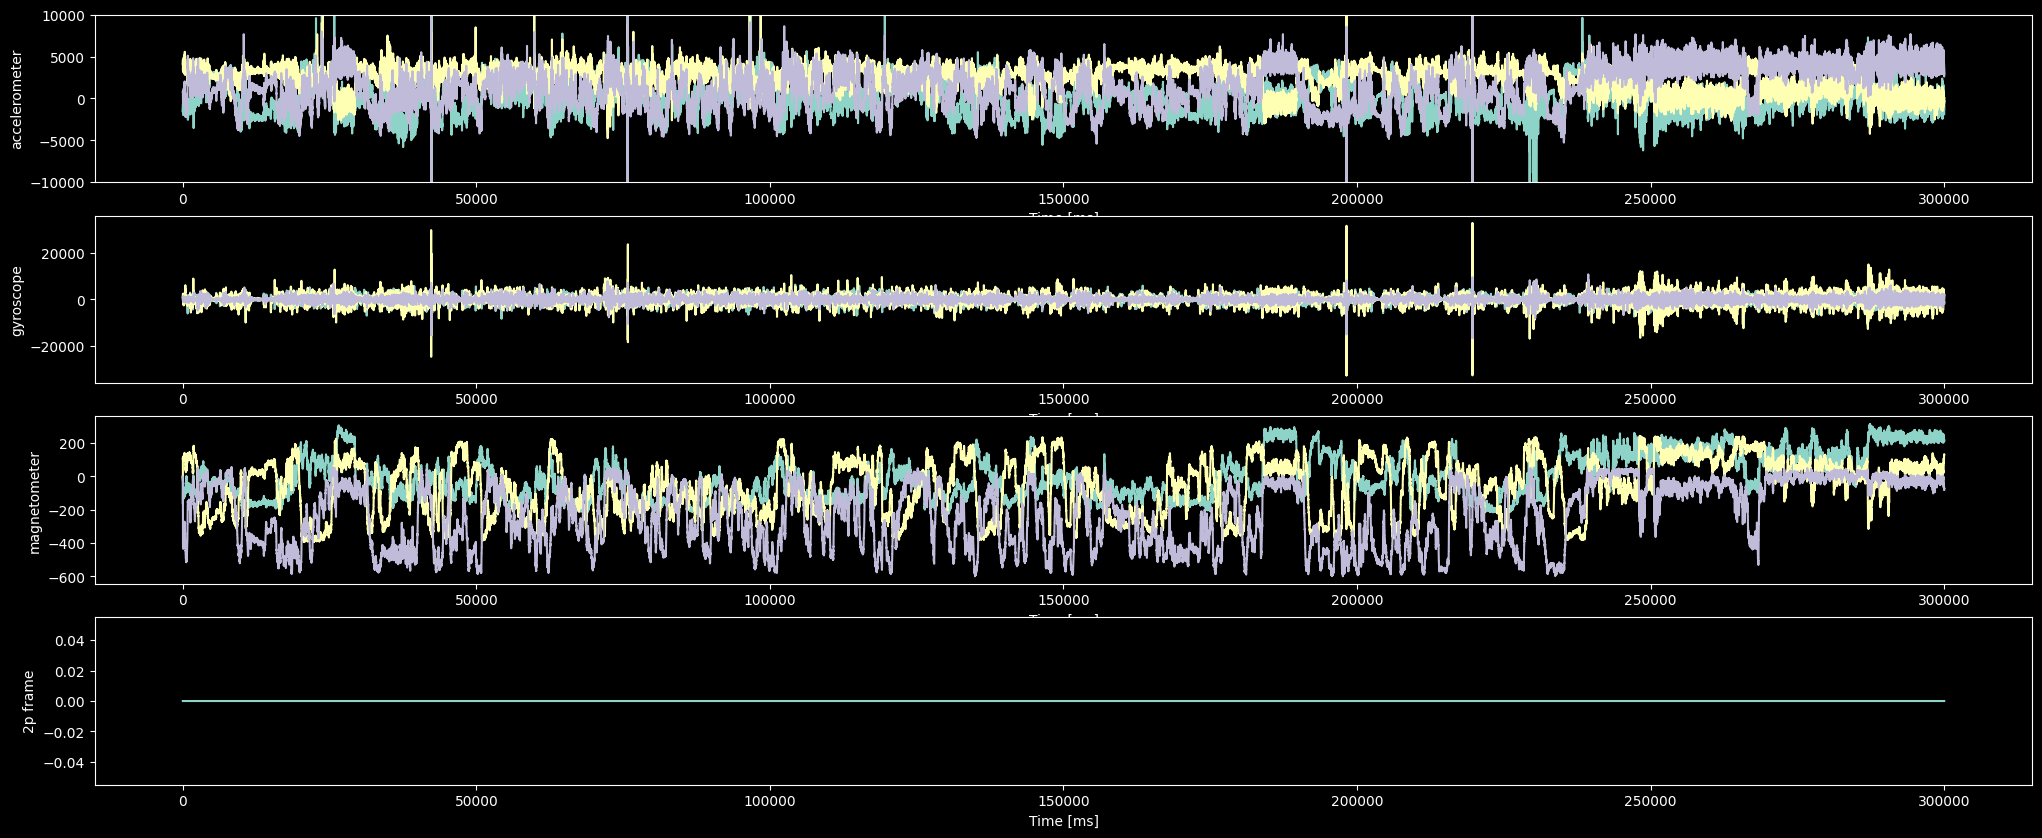

In [39]:
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(25, 10))
# plt.rcParams['agg.path.chunksize'] = 10000  # Add this line if it does not rende


for i, arr in enumerate(accelerometer):
    axes[0].plot(arr, label=f'accelerometer {i+1}')
    
axes[0].set_ylim([-10000, 10000])
axes[0].set_ylabel("accelerometer")
axes[0].set_xlabel("Time [ms]")

for i, arr in enumerate(gyroscope):
    axes[1].plot(arr, label=f'gyroscope {i+1}')
    
axes[1].set_ylabel("gyroscope")
axes[1].set_xlabel("Time [ms]")

for i, arr in enumerate(magnetometer):
    axes[2].plot(arr, label=f'magnetometer {i+1}')
    
axes[0].set_ylim([-10000, 10000])
axes[2].set_ylabel("magnetometer")
axes[2].set_xlabel("Time [ms]")


for i, arr in enumerate(twopframes):
    axes[3].plot(twopframes[0][:-1], label=f'2p frames {i+1}')
    
# axes[2].set_ylim([-10, 370])
axes[3].set_ylabel("2p frame")
axes[3].set_xlabel("Time [ms]")


plt.show() 

In [ ]:
event.EventType()

In [ ]:
auxgatetimestamp_start = (event.Event()  &  "event_type = 'HARP_gate'" &  scan_key ).fetch('event_start_time')
auxgatetimestamp_end = (event.Event()  &  "event_type = 'HARP_gate'" &  scan_key ).fetch('event_end_time')

print(auxgatetimestamp_start)
print(auxgatetimestamp_end)

In [ ]:
twopptimeoff = twopptime[0] + auxgatetimestamp_start * 1000
print(twopptimeoff[0] / 1000)
print(twopptimeoff[-1] / 1000)

In [ ]:
auxgatetimestamp_start